In [1]:
from MASH import MASH
import numpy as np
import pandas as pd
import test_manifold_algorithms as tma
import matplotlib.pyplot as plt
from SPUD import SPUD
from SPUD_Copy import SPUD_Copy

2024-08-03 15:43:16.349134: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-03 15:43:16.355120: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-03 15:43:16.457566: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 15:43:18.559449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Testing With MASH

## General Tests

In [14]:
from MASH import MASH
import test_manifold_algorithms as tma

dcG = tma.test_manifold_algorithms(csv_file="hepatitis.csv", split = "distort", percent_of_anchors= [0.2], verbose = 2, random_state= 42)


 
 
---------------------------       Initalizing class with hepatitis.csv data       ---------------------------

Creating a mirror dataset and distorting the features in the second Domain
Split A features shape: (138, 15)
Split B Features shape (138, 15)
MDS initialized with 15 components
The knn values are: (2, 5, 8, 11, 14, 17, 20, 23, 26, 29)


In [18]:
mclass = MASH(t = 10, knn = 5, distance_measure_A="euclidean",  distance_measure_B="euclidean", DTM = "log", burn_in = 0, verbose = 3)
mclass.fit(dcG.split_A, dcG.split_B, dcG.anchors[:15])

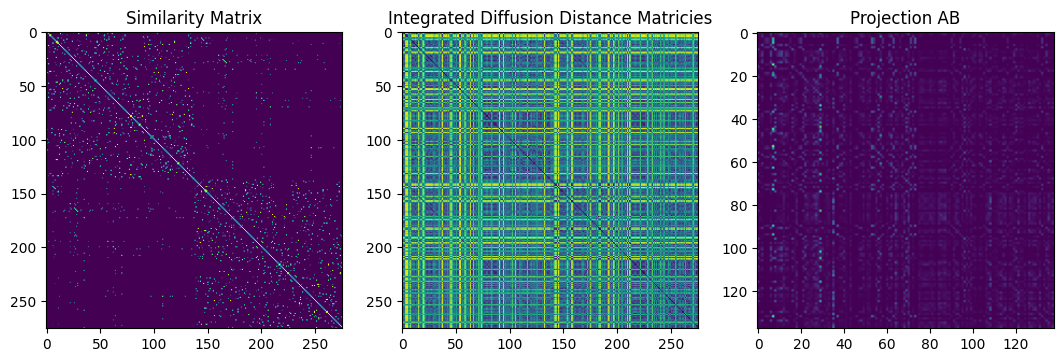

In [19]:
mclass.plot_heat_maps()

Cross Embedding: 0.7463768115942029
FOSCTTM: 0.058181054400336066


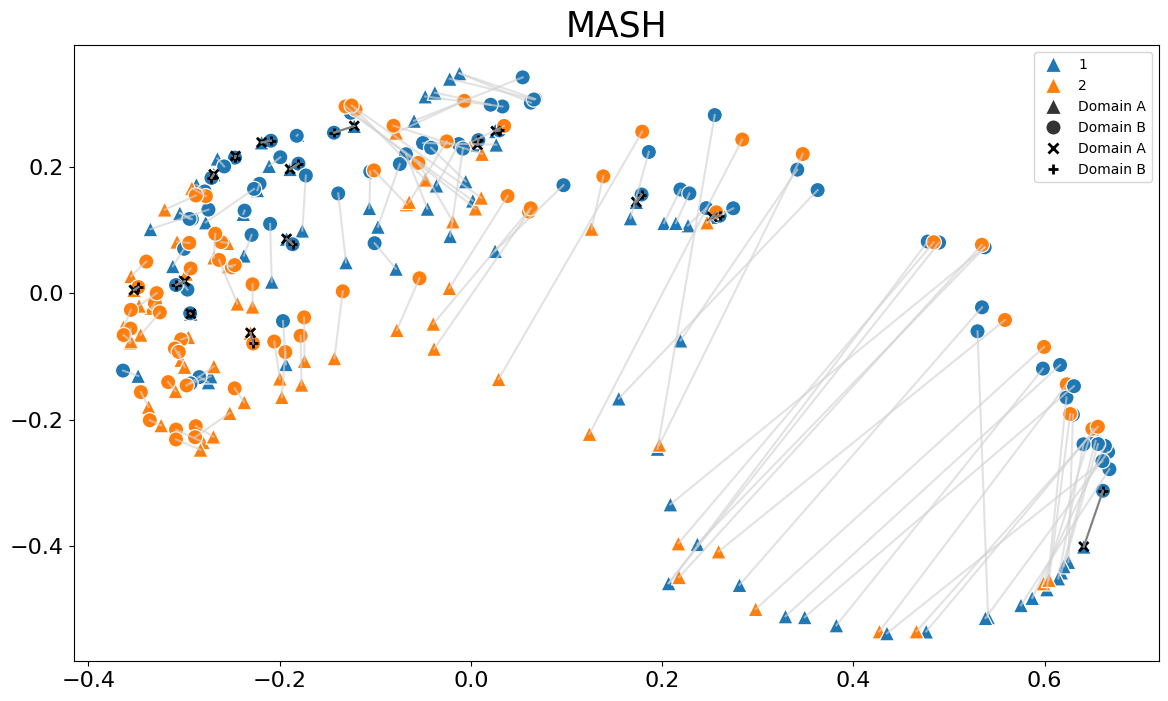

In [20]:
mclass.plot_emb(labels = dcG.labels_doubled)

## Time Tests

In [1]:
from MASH import MASH
import test_manifold_algorithms as tma

dc3 = tma.test_manifold_algorithms(csv_file="iris.csv", split = "distort", percent_of_anchors= [0.2], verbose = 2, random_state= 42)

2024-07-31 11:08:53.509277: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 11:08:53.514963: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 11:08:53.617620: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 11:08:55.576053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

Creating a mirror dataset and distorting the features in the second Domain
Split A features shape: (150, 4)
Split B Features shape (150, 4)
MDS initialized with 4 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [2]:
mclass = MASH(t = -1, knn = 5, distance_measure_A="default",  distance_measure_B="euclidian", DTM = "log", verbose = 4)
mclass.fit(dc3.split_A, dc3.split_B, dc3.anchors[:15])

Time Data Below
 Time it took to execute the graph for domain A:  0.08051
 Time it took to compute kernal A:  0.00025
 Time it took to execute SGDM for domain B:  0.00066
 Time it took to execute the graph for domain B:  0.07217
 Time it took to compute merge_graphs function:  0.04825
 Time it took to compute similarity_matrix function:  0.00064
Using optimal t value of 21
 Time it took to compute diffusion process:  0.04865


# Testing With SPUD

In [1]:
from SPUD import SPUD
import test_manifold_algorithms as tma

dc3 = tma.test_manifold_algorithms(csv_file="iris.csv", split = "random", percent_of_anchors= [0.2], verbose = 2, random_state= 42)

2024-08-06 21:58:53.451422: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 21:58:53.457940: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 21:58:53.562663: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 21:58:56.019281: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

Splitting the data randomly
Split A features shape: (150, 3)
Split B Features shape (150, 1)
MDS initialized with 2 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


## General SPUD tests

In [21]:
##### WE NEED TO CHECK TO SEE IF THE SPARSE MATRIX WILL STILL WORK WITH ALL THE OPERANDS AND WITH GRAPH TOOLS DISTANCES ##### ARE the sizes correct? They seem to big??
sclass = SPUD(knn = 35, OD_method="abs", agg_method= 1.5, distance_measure_A="euclidean", distance_measure_B="euclidean", verbose = 3)
sclass.fit(dc3.split_A, dc3.split_B, dc3.anchors[:10])
sclass.plot_emb(dc3.labels_doubled, show_lines = False, show_anchors = False, show_legend = False, n_comp = 2)

Preforming abs calculations. Setting the use of kernals to true.
---------------------------------------------------------


AxisError: axis 1 is out of bounds for array of dimension 1

In [38]:
import numpy as np

# Example subsetted and flattened upper triangular matrix
upper_triangle = np.array([11, 3, 5, 6, 8, 9])

# Corresponding indices
indices = np.array([0, 0, 1, 0, 1, 2])

# Create an instance to call the method (assuming within a class, otherwise, remove self)
class Example:
    def get_triangular_min(self, upper_triangle, indices):
        """Upper_triangle is a subsetted and flattened upper_triangle of a matrix.
           Indices tell us which values are kept and which values were subsetted out."""
        
        # Incase some indices were skipped. TODO: upgrade this for when the labels aren't continuous
        indices -= indices.min()

        # Determine the size of the original matrix
        size = indices.max() + 1

        # Create a mask to filter out the relevant entries for each row
        rows = np.unique(indices)
        min_values = np.full(size, np.inf)  # Initialize with infinity
        min_indices = np.full(size, -1)  # Initialize with -1

        for row in rows:
            row_mask = indices == row
            if np.any(row_mask):
                row_values = upper_triangle[row_mask]
                col_indices = indices[row_mask]
                min_index = np.argmin(row_values)
                min_values[row] = row_values[min_index]
                min_indices[row] = col_indices[min_index]

        # Filter out rows that were not part of the subset (remain as initialized values)
        valid_mask = min_indices != -1

        return min_values[valid_mask], valid_mask
    
    def index_triangular(self, upper_triangular, columns, return_indices=False):
        """Indexes the triangular matrix. If rows or columns are set to None, it returns all of them.
        If return_indices is True, it also returns the indices and the mask used for indexing."""

        # Check to see if the ndim = 1, else it's already built
        if upper_triangular.ndim == 1:

            # Get the size of the original matrix
            size = int((-1 + np.sqrt(1 + (8 * upper_triangular.size))) // 2)
            indices = np.triu_indices(size)

            # Create the mask for the specified columns
            col_mask = np.isin(indices[1], columns)

            # Create the mask for the symmetric counterparts in the lower triangle
            row_mask = np.isin(indices[0], columns)

            # Combine the row_mask with the off_diagonal_mask
            row_mask = row_mask & (indices[0] != indices[1])


            # Apply the combined mask to indices
            indices = np.concatenate((indices[0][col_mask], indices[1][row_mask]))
            upper_triangular = np.concatenate((upper_triangular[col_mask], upper_triangular[row_mask]))

            if return_indices:
                # Return the matrix, its indices, and mask
                return upper_triangular, indices
            else:
                # Just return the matrix
                return upper_triangular
            
        else:

            # If the input is already a matrix, apply the row and column selection directly
            upper_triangular = upper_triangular[:, columns]

            return upper_triangular
    
    
    def reconstruct_symmetric(self, upper_triangular):
        """Rebuilds the triangular to a symmetric graph"""

        #Check to see if the ndim = 1, else its already built
        if upper_triangular.ndim == 1:

            #Cache size for faster processing
            size = int((-1 + np.sqrt(1 + (8 * upper_triangular.size))) // 2)

            #Create a matrix filled with zeros
            matrix = np.zeros((size, size))

            #Get the indicies for the upper trianglar
            indices = np.triu_indices(size)

            #Reset the matrix
            matrix[indices] = upper_triangular

            # Mirror the upper part to the lower part
            matrix[(indices[1], indices[0])] = upper_triangular 

            return matrix
        
        else:
            return upper_triangular

# Example call
example = Example()
print(example.reconstruct_symmetric(upper_triangle), "\n")
upper_triangle, indices = example.index_triangular(upper_triangular=upper_triangle, columns = [0,1,2], return_indices=True)
min_values, min_indices = example.get_triangular_min(upper_triangle, indices)
print("Minimum Values:", min_values)
print("Corresponding Column Indices:", min_indices)
print("Upper Triangle", upper_triangle)



[[11.  3.  5.]
 [ 3.  6.  8.]
 [ 5.  8.  9.]] 

Minimum Values: [3. 3. 5.]
Corresponding Column Indices: [ True  True  True]
Upper Triangle [11  3  5  6  8  9  3  5  8]


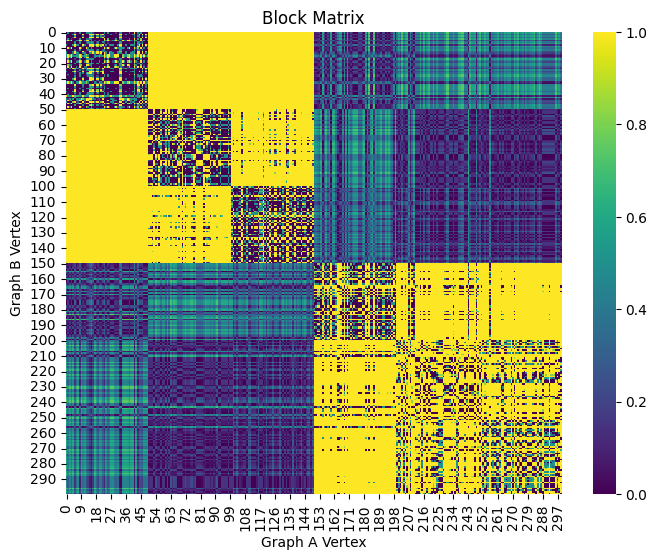

In [20]:
sclass.plot_heat_map()

## Time Tests

In [6]:
dc4 = tma.test_manifold_algorithms(csv_file="waveform.csv", split = "distort", percent_of_anchors= [0.2], verbose = 2, random_state= 42)
sclass = SPUD(knn = 1000, OD_method= "mean", agg_method = "normalize", verbose = 4)
sclass.fit(dc4.split_A, dc4.split_B, dc4.anchors[:1500])
#sclass.plot_emb(dc3.labels_doubled, show_lines = False, show_anchors = False, show_legend = False)


 
 
---------------------------       Initalizing class with waveform.csv data       ---------------------------

Creating a mirror dataset and distorting the features in the second Domain
Split A features shape: (5000, 40)
Split B Features shape (5000, 40)
MDS initialized with 40 components
The knn values are: (2, 103, 204, 305, 406, 507, 608, 709, 810, 911)
Time Data Below
 Time it took to compute SGDM:  3.09


/yunity/arusty/.local/lib/python3.10/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (5000, 5000) is expensive. Consider setting n_pca.
  warnings.warn(
/yunity/arusty/.local/lib/python3.10/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (5000, 5000) is expensive. Consider setting n_pca.
  warnings.warn(


 Time it took to execute graphtools.Graph functions:  91.16
Preforming mean calculations. Setting the use of kernals to true.
---------------------------------------------------------
 Time it took to execute get_block function:  2.84
<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>


In [86]:
#Create a results table
import pandas as pd
pd.DataFrame(columns = ["CSV File", "Feature Shape",  "Anchor Count", "KNN", "SGDM Time", "Graph Time", "Merge Time", "Get Block Time"],
             data = [["optdigits",    (3823, 41),          1500,        2,     1.11,       23.78,       0.01,      29.92 ],
                     ["optidigits",  (3823, 41),           1500,        500,   1.25,       38.24,     2.37,          1296.43],
                     ["optidigits",  (3823, 64),           15,           5,    1.38,             25.17,         0.02,          33.32],
                     ["chess",          (3196, 36),        1500,        500,      0.78,         21.51,         1.65,           674.48 ],
                     ["chess",          (3196, 36),        15,        500,      0.65,         20.33,         1.73,           682.11 ],
                     ["chess",          (3196, 36),        15,        5,      0.63,         15.47,         0.01,             20.07 ],
                     ["Waveform",     (5000, 40),         15,        5,        1.92,           58.67,       0.02,               67.54 ],
                     ["Waveform",     (5000, 40),         1500,        1000,        1.90,     90.78,       6.51,         4924.34],
   ["Waveform - OD_method = abs",     (5000, 40),         1500,        1000,        3.09,       91.16,      0.00,            2.84], #WOW! Look at this craxy time reduction!!!!
                     ["Iris",     (150, 4),               150,        148,        0,            0.16,       0.01,         0.18]])

,CSV File,Feature Shape,Anchor Count,KNN,SGDM Time,Graph Time,Merge Time,Get Block Time
0,optdigits,"(3823, 41)",1500,2,1.11,23.78,0.01,29.92
1,optidigits,"(3823, 41)",1500,500,1.25,38.24,2.37,1296.43
2,optidigits,"(3823, 64)",15,5,1.38,25.17,0.02,33.32
3,chess,"(3196, 36)",1500,500,0.78,21.51,1.65,674.48
4,chess,"(3196, 36)",15,500,0.65,20.33,1.73,682.11
5,chess,"(3196, 36)",15,5,0.63,15.47,0.01,20.07
6,Waveform,"(5000, 40)",15,5,1.92,58.67,0.02,67.54
7,Waveform,"(5000, 40)",1500,1000,1.90,90.78,6.51,4924.34
8,Waveform - OD_method = abs,"(5000, 40)",1500,1000,1.96,91.78,Memory Failure,Memory Failure
9,Iris,"(150, 4)",150,148,0.00,0.16,0.01,0.18


In [5]:
4924.34/60

82.07233333333333

# Sparse Data Tests

In [71]:
import numpy as np
sparse_dc = tma.test_manifold_algorithms(csv_file="Cancer_Data.csv", split= "skewed", percent_of_anchors= [0.8], verbose=2, random_state=25)
sparse_dc.split_A = sparse_dc.split_A
sparse_dc.split_B = sparse_dc.split_B
#Randomly select points
import random
random_points = random.sample(range(len(sparse_dc.split_A)), k = int(len(sparse_dc.split_A)/10))

#Create the macthing anchors
sparse_dc.anchors = np.array([range(int(len(sparse_dc.split_A)/10)), random_points]).T

#Subset split A to only have some of the points
sparse_dc.split_A = sparse_dc.split_A[random_points]

#Create labels
sparse_labels = np.hstack([sparse_dc.labels[random_points], sparse_dc.labels])


 
 
---------------------------       Initalizing class with Cancer_Data.csv data       ---------------------------

Splitting the data in a skewed fashion
Split A features shape: (569, 15)
Split B Features shape (569, 15)
MDS initialized with 15 components
The knn values are: (2, 14, 26, 38, 50, 62, 74, 86, 98, 110)


In [81]:
sclass = SPUD(knn = 10, OD_method= "abs", agg_method = "normalize", verbose = 3, random_state = 10)
sclass.fit(sparse_dc.split_A, sparse_dc.split_B, sparse_dc.anchors)

/yunity/arusty/.local/lib/python3.10/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (569, 569) is expensive. Consider setting n_pca.
  warnings.warn(


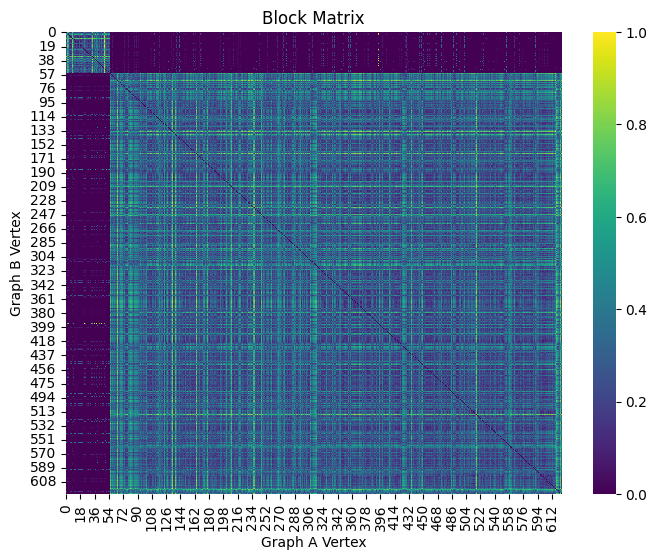

In [82]:
sclass.plot_heat_map()

Cross Embedding: 0.7960864925935225
Can't compute FOSCTTM with different domain shapes.


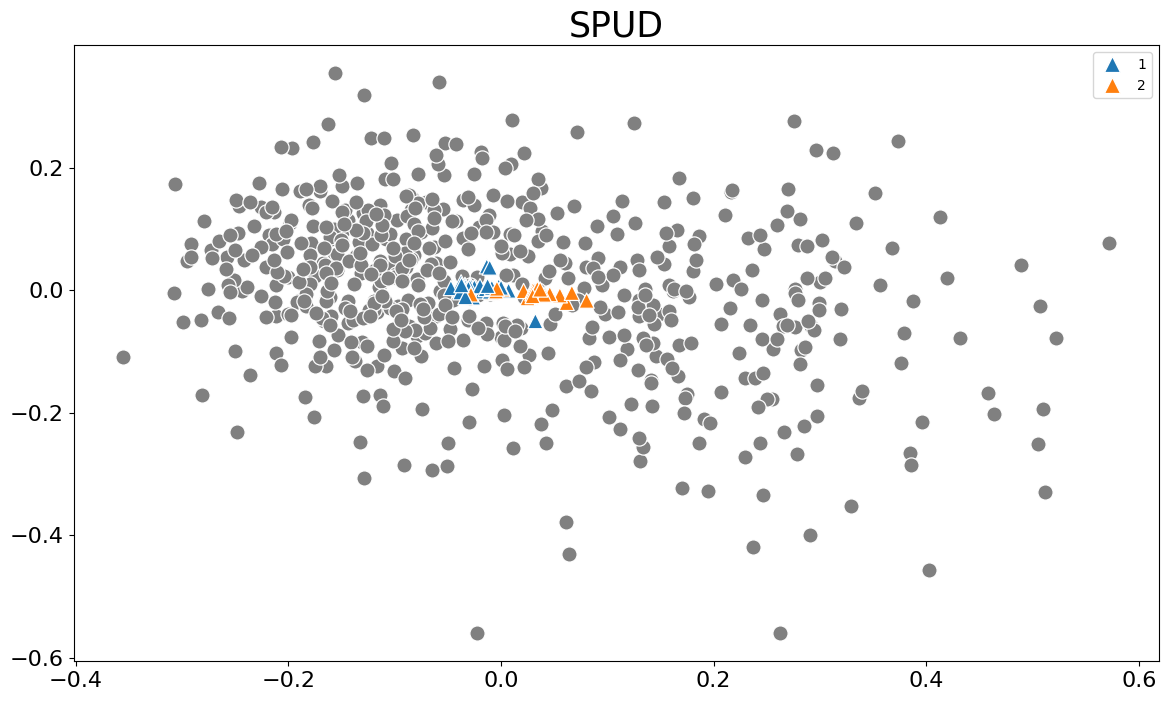

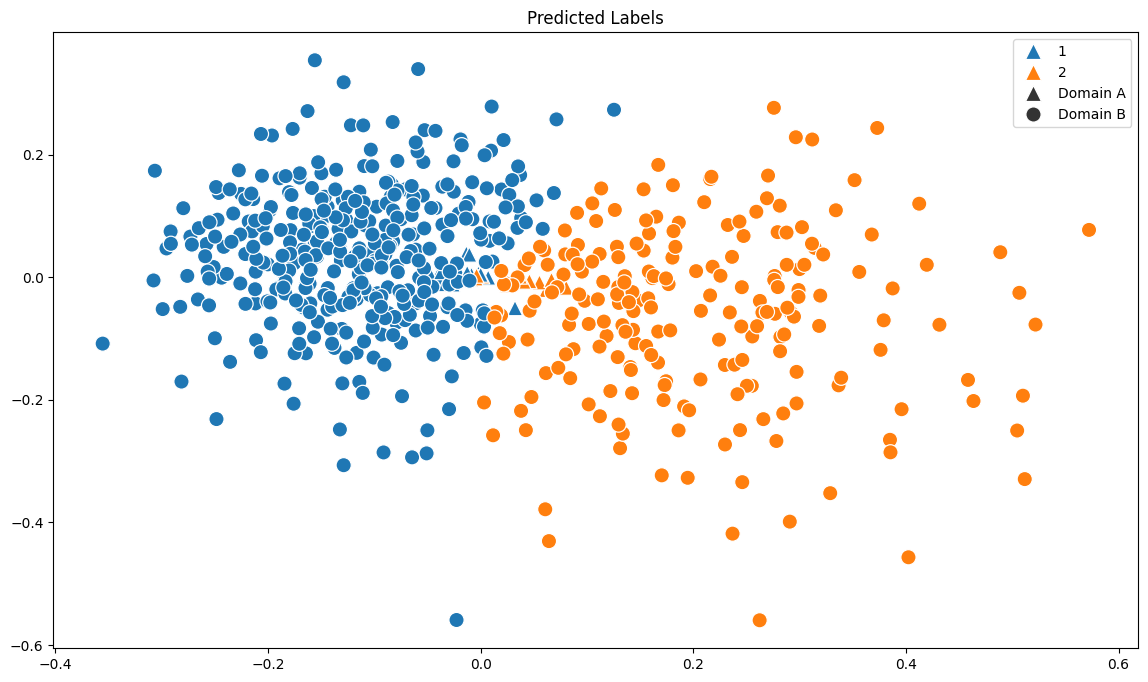

In [83]:
sclass.plot_emb(sparse_labels, show_lines = False, show_anchors = False, show_pred= True)

In [66]:
dclass = MASH(knn = 8, DTM = "log", verbose = 3)
dclass.fit(sparse_dc.split_A, sparse_dc.split_B, sparse_dc.anchors)
dclass.plot_emb(sparse_labels, show_lines = False, show_pred = True, show_legend = False, n_comp = 4)

NameError: name 'MASH' is not defined

In [ ]:
len(B_emb), len(sparse_dc.labels)

(699, 699)

In [49]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

pca = PCA(n_components=min(len(sparse_dc.split_A[1]), len(sparse_dc.split_B[1])))
A_emb = pca.fit_transform(sparse_dc.split_A)
B_emb = pca.fit_transform(sparse_dc.split_B)

#Initilize model
model = KNeighborsClassifier(n_neighbors = 8)


#Split data and train for split A

model.fit(A_emb, sparse_dc.labels[random_points])
print(f"    Classification Score trained on A {model.score(B_emb, sparse_dc.labels)}")

#Split data and train for split B
try:
    model.fit(B_emb, sparse_dc.labels)
    print(f"    Classification Score trained on B {model.score(A_emb, sparse_dc.labels[random_points])}")
except:
    print(f"    Classification Score trained on B Failed")

    Classification Score trained on A 0.9642346208869814
    Classification Score trained on B 0.9130434782608695
